In [3]:
# Inicjalizacja
!pip install --upgrade tables
!pip install eli5

import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5

from eli5.sklearn import PermutationImportance

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


## Wczytywanie danych

In [6]:
cd "/content/drive/My Drive/Colab Notebooks/matrix/matrix_two/dw_matrix_car"

/content/drive/My Drive/Colab Notebooks/matrix/matrix_two/dw_matrix_car


In [14]:
# Czytamy dane z pliku
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

In [12]:
# Jakie mamy kolumny
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

## Dummy Model

In [13]:
# Ile cech ma wartość liczbową
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [29]:
# Prosty model
feats = ['car_id']
X = df [ feats ].values
y = df [ 'price_value'].values

model = DummyRegressor()

# Trenujemy model
model.fit(X,y)

# Przewidujemy
y_pred = model.predict(X)

# Maximum Estimated Error - miara jakości - - różnica między cenami rzeczywistymi a prognozowanymi przez model
mae(y, y_pred)

39465.934630440985

In [30]:
# Prosty model
feats = ['car_id']
X = df [ feats ].values
y = df [ 'price_value'].values

# Strategia działania modelu - MEDIANA zamiast średniej
model = DummyRegressor(strategy="median")

# Trenujemy model
model.fit(X,y)

# Przewidujemy
y_pred = model.predict(X)

# Maximum Estimated Error - miara jakości - różnica między cenami rzeczywistymi a prognozowanymi przez model
mae(y, y_pred)

33787.86762747197

In [32]:
# Która kolumna zawiera słowo 'price'
[x for x in df.columns if 'price' in x]

['price_currency', 'price_details', 'price_value']

In [34]:
# Ile jakich wartości
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [35]:
# Normalizujemy eurasy (procentowa zawartość cen podanych w euro wśród całości ogłoszeń)
df['price_currency'].value_counts(normalize=True) *100

PLN    99.80844
EUR     0.19156
Name: price_currency, dtype: float64

In [36]:
# Nieładnie, ale usuwamy wszystkie rekordy z cenami podanymi w EUR
df = df[ df['price_currency'] != 'EUR' ]
df.shape

(106290, 155)

## Przygotowanie cech

In [41]:
# Przypisujemy do wartości tej kolumny (czarny, srebrny, etc) wartości liczbowe
df['param_color'].factorize()

(array([-1, -1, -1, ..., -1, -1, -1]),
 Index(['Czarny', 'Srebrny', 'Złoty', 'Bordowy', 'Biały', 'Szary', 'Beżowy',
        'Zielony', 'Fioletowy', 'Niebieski', 'Inny kolor', 'Brązowy', 'Żółty'],
       dtype='object'))

In [42]:
# Przypisujemy powyższe, interesuje nas tylko wartość liczbowa
df['param_color'].factorize()[0]

array([-1, -1, -1, ..., -1, -1, -1])

In [40]:
for feat in df.columns:
  print(feat)

breadcrumb
created_at
price_currency
price_details
price_value
seller_address
seller_name
seller_type
feature_czujniki-parkowania-przednie
feature_poduszka-powietrzna-chroniąca-kolana
feature_kurtyny-powietrzne
feature_klimatyzacja-dwustrefowa
feature_światła-led
feature_czujnik-zmierzchu
feature_elektrycznie-ustawiane-lusterka
feature_asr-(kontrola-trakcji)
feature_poduszka-powietrzna-kierowcy
feature_cd
feature_elektryczne-szyby-przednie
feature_poduszka-powietrzna-pasażera
feature_system-start-stop
feature_światła-do-jazdy-dziennej
feature_komputer-pokładowy
feature_elektryczne-szyby-tylne
feature_klimatyzacja-manualna
feature_tapicerka-welurowa
feature_czujnik-deszczu
feature_światła-przeciwmgielne
feature_ogrzewanie-postojowe
feature_radio-niefabryczne
feature_regulowane-zawieszenie
feature_ogranicznik-prędkości
feature_zmieniarka-cd
feature_szyberdach
feature_isofix
feature_asystent-pasa-ruchu
feature_alufelgi
feature_bluetooth
feature_nawigacja-gps
feature_asystent-parkowania
fe

In [0]:
# Faktoryzujemy każdą z cech (w każdej z kolumn) i przypisujemy suffix
SUFFIX_CAT = '__cat'

for feat in df.columns:
  # Jeśli zawartość cechy jest listą, pomiń
  if isinstance(df[feat][0], list):continue

  # Żeby nie duplikować suffixów '__cat', tzn. nie faktoryzować już sfaktoryzowanych cech
  factorized_values = df[feat].factorize()[0]
  if SUFFIX_CAT in feat:
    df[feat] = factorized_values
  else:
    df[feat + SUFFIX_CAT] = factorized_values

In [51]:
# printujemy wszystkie cechy, w których dodaliśmy suffixy
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]
cat_feats

['created_at__cat',
 'price_currency__cat',
 'price_details__cat',
 'price_value__cat',
 'seller_address__cat',
 'seller_name__cat',
 'seller_type__cat',
 'feature_czujniki-parkowania-przednie__cat',
 'feature_poduszka-powietrzna-chroniąca-kolana__cat',
 'feature_kurtyny-powietrzne__cat',
 'feature_klimatyzacja-dwustrefowa__cat',
 'feature_światła-led__cat',
 'feature_czujnik-zmierzchu__cat',
 'feature_elektrycznie-ustawiane-lusterka__cat',
 'feature_asr-(kontrola-trakcji)__cat',
 'feature_poduszka-powietrzna-kierowcy__cat',
 'feature_cd__cat',
 'feature_elektryczne-szyby-przednie__cat',
 'feature_poduszka-powietrzna-pasażera__cat',
 'feature_system-start-stop__cat',
 'feature_światła-do-jazdy-dziennej__cat',
 'feature_komputer-pokładowy__cat',
 'feature_elektryczne-szyby-tylne__cat',
 'feature_klimatyzacja-manualna__cat',
 'feature_tapicerka-welurowa__cat',
 'feature_czujnik-deszczu__cat',
 'feature_światła-przeciwmgielne__cat',
 'feature_ogrzewanie-postojowe__cat',
 'feature_radio-ni

In [52]:
# Ile tego
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]
len(cat_feats)

154

In [53]:
# Usuwamy zmienne zawierające słowo 'price' (bo to zmienna docelowa)
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [54]:
# No i tworzymy model
X = df[cat_feats].values
y = df['price_value'].values

# nie używać za dużej głębokości
model = DecisionTreeRegressor(max_depth=5)

# Z jakiegośtam powodu używamy negatywnej / ujemnej wartości średniej błędu
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-19566.588937368328

In [57]:
# Sprawdzamy które cechy są najciekawsze
model2 = DecisionTreeRegressor(max_depth=5)
model2.fit(X,y)

imp = PermutationImportance(model2, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names = cat_feats)

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


In [59]:
df['param_napęd'].unique()

array([None, 'Na przednie koła', '4x4 (dołączany automatycznie)',
       'Na tylne koła', '4x4 (dołączany ręcznie)', '4x4 (stały)'],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f99628957b8>,
      dtype=object)

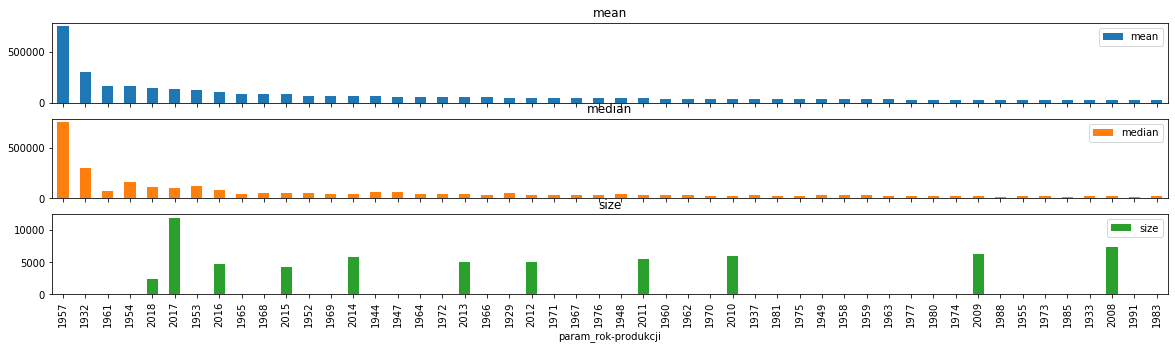

In [73]:
def group_and_barplot(feat_groupby, feat_agg='price_value', agg_funcs=[np.mean, np.median, np.size], feat_sort='mean', top=50, subplots=True):
  return (
            df
            .groupby(feat_groupby)[feat_agg]
            .agg(agg_funcs)
            .sort_values(by=feat_sort, ascending=False)
            .head(top)
          ).plot(kind='bar', figsize=(20,5), subplots=subplots)

group_and_barplot('param_rok-produkcji')